In [1]:
# 필요한 라이브러리 설치
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve

## 주어진 data (lendingclub_train.dta) 전처리

In [2]:
# 데이터 파일 불러오기
file_name = '/Users/limdonggeon/Desktop/SNU_FINTECH/Statics_DataScience_Statics/team_project/lendingclub_train.dta'
df = pd.read_stata(file_name)

In [3]:
df.shape

(874335, 334)

In [4]:
print(df.columns)

Index(['index', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate',
       'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low',
       ...
       'mths_since_recent_revol_delinq2', 'mths_since_recent_revol_delinq3',
       'mths_since_recent_revol_delinq4', 'mths_since_recent_revol_delinq5',
       'mths_since_recent_revol_delinq6', 'mths_since_recent_revol_delinq7',
       'mths_since_recent_revol_delinq8', 'mths_since_recent_revol_delinq9',
       'mths_since_recent_revol_delinq10', 'mths_since_recent_revol_delinq11'],
      dtype='object', length=334)


In [5]:
# 돈을 벌어다 주는 액수 remain 설정
df['remains'] = (df['total_pymnt']-df['funded_amnt'])

/var/folders/fs/zfypqyv96hs22x794hfx0ycm0000gn/T/ipykernel_1322/1451665987.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['remains'] = (df['total_pymnt']-df['funded_amnt'])


In [6]:
# 돈을 벌어다 주는 loan_not_access 설정
df['loan_not_access'] = np.where(df['funded_amnt'] > df['total_pymnt'], 1, 0)
len(df[df['loan_not_access']==1])

/var/folders/fs/zfypqyv96hs22x794hfx0ycm0000gn/T/ipykernel_1322/2976678536.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['loan_not_access'] = np.where(df['funded_amnt'] > df['total_pymnt'], 1, 0)


122790

In [7]:
# 이상치라고 판단되는 값들 제거 ( EDA 총정리 코드에서 인덱스 확인 가능 )
new_df = df.copy()
delete_index = [331118, 829091, 474252, 733418]
for k in range(df.shape[0]):
    if df['index'].values[k] in delete_index:
        new_df = new_df.drop(k, axis=0)

In [8]:
# 원래 데이터에서 사전 변수라고 생각하는 데이터만 따로 뽑아 모델을 만들 데이터 셋 구축
df_data= new_df[['remains','loan_not_access', 'loan_amnt', 'int_rate', 'annual_inc', 'dti', 'delinq_2yrs', 'open_acc', 'fico_range_low','pub_rec', 'revol_bal',
                 'revol_util', 'total_acc', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'chargeoff_within_12_mths', 'pub_rec_bankruptcies', 'tax_liens',
                 'emp_length1', 'emp_length2', 'emp_length3', 'emp_length4', 'emp_length5', 'emp_length6', 'emp_length7', 'emp_length8', 'emp_length9', 'emp_length10', 'emp_length11', 'emp_length12',
                 'home_ownership1', 'home_ownership2', 'home_ownership3', 'home_ownership4', 'home_ownership5', 'home_ownership6', 'verification_status1', 'verification_status2', 'verification_status3',
                 'purpose1', 'purpose2', 'purpose3', 'purpose4', 'purpose5', 'purpose6', 'purpose7', 'purpose8', 'purpose9', 'purpose10', 'purpose11', 'purpose12', 'purpose13', 'purpose14',
                 'addr_state1', 'addr_state2', 'addr_state3', 'addr_state4', 'addr_state5', 'addr_state6', 'addr_state7', 'addr_state8', 'addr_state9', 'addr_state10',
                 'addr_state11', 'addr_state12', 'addr_state13', 'addr_state14', 'addr_state15', 'addr_state16', 'addr_state17', 'addr_state18', 'addr_state19', 'addr_state20',
                 'addr_state21', 'addr_state22', 'addr_state23', 'addr_state24', 'addr_state25', 'addr_state26', 'addr_state27', 'addr_state28', 'addr_state29', 'addr_state30',
                 'addr_state31', 'addr_state32', 'addr_state33', 'addr_state34', 'addr_state35', 'addr_state36', 'addr_state37', 'addr_state38', 'addr_state39', 'addr_state40',
                 'addr_state41', 'addr_state42', 'addr_state43', 'addr_state44', 'addr_state45', 'addr_state46', 'addr_state47', 'addr_state48', 'addr_state49', 'addr_state50',
                 'addr_state51', 'initial_list_status1', 'initial_list_status2', 'term1']]


In [9]:
# 모델의 정확도를 높이기 위해 0의 값을 갖는 비율이 0.3% 이하를 갖는 컬럼을 제거
for i in df_data.columns:
    if len(df_data[df_data[i] == 0])/len(df_data[i]) > 0.997:
        df_data = df_data.drop(i, axis=1)


In [10]:
df_data.columns

Index(['remains', 'loan_not_access', 'loan_amnt', 'int_rate', 'annual_inc',
       'dti', 'delinq_2yrs', 'open_acc', 'fico_range_low', 'pub_rec',
       'revol_bal', 'revol_util', 'total_acc', 'acc_now_delinq',
       'tot_coll_amt', 'tot_cur_bal', 'chargeoff_within_12_mths',
       'pub_rec_bankruptcies', 'tax_liens', 'emp_length1', 'emp_length2',
       'emp_length3', 'emp_length4', 'emp_length5', 'emp_length6',
       'emp_length7', 'emp_length8', 'emp_length9', 'emp_length10',
       'emp_length11', 'emp_length12', 'home_ownership2', 'home_ownership5',
       'home_ownership6', 'verification_status1', 'verification_status2',
       'verification_status3', 'purpose1', 'purpose2', 'purpose3', 'purpose5',
       'purpose6', 'purpose7', 'purpose8', 'purpose9', 'purpose10',
       'purpose12', 'purpose13', 'addr_state2', 'addr_state3', 'addr_state4',
       'addr_state5', 'addr_state6', 'addr_state7', 'addr_state10',
       'addr_state11', 'addr_state12', 'addr_state15', 'addr_state16',

## 모델 : Linear Regression

In [11]:
# X와 y로 데이터 분리
X = df_data.drop(['remains','loan_not_access'], axis=1)
y = df_data[['remains','loan_not_access']]

# 전체 데이터셋을 train:validation:test 셋을 6:2:2로 분리
# 우선 전체 데이터를 train과 나머지로 분리 (train: 나머지 = 6:4)
X_train_1, X_temp, y_train_1, y_temp = train_test_split(X, y, test_size=0.4, random_state=0, stratify = y['loan_not_access'])

# 나머지 데이터를 validation과 test로 분리 (validation: test = 1:1)
X_val_1, X_test_1, y_val_1, y_test_1 = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0, stratify = y_temp['loan_not_access'])


# 수치형 변수들만 scaling 필요
numerical_cols = ['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'delinq_2yrs', 'open_acc', 'fico_range_low',
        'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'chargeoff_within_12_mths', 'pub_rec_bankruptcies', 'tax_liens']

# 수치형 데이터 scaling
scaler = StandardScaler()
X_train_numeric = scaler.fit_transform(X_train_1[numerical_cols])
X_val_numeric = scaler.transform(X_val_1[numerical_cols])         # train set과 scaling 똑같이 적용
X_test_numeric = scaler.transform(X_test_1[numerical_cols])       # train set과 scaling 똑같이 적용


# 더미변수도 추가해 train, validatiaon, test 데이터 셋 구성 다시하기
X_train = np.hstack((X_train_numeric, X_train_1.drop(numerical_cols, axis = 1)))
X_val = np.hstack((X_val_numeric, X_val_1.drop(numerical_cols, axis = 1)))
X_test = np.hstack((X_test_numeric, X_test_1.drop(numerical_cols, axis = 1)))

# y 에서 loan_not_aceess 제거
y_train = y_train_1.drop('loan_not_access',axis = 1) 
y_val = y_val_1.drop('loan_not_access',axis = 1)
y_test = y_test_1.drop('loan_not_access',axis = 1)

In [12]:
# 나눈 데이터 셋 크기 확인
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape


((524598, 88),
 (174866, 88),
 (174867, 88),
 (524598, 1),
 (174866, 1),
 (174867, 1))

In [13]:
from sklearn.linear_model import LinearRegression

# 로지스틱 회귀 모델 생성
linear_model = LinearRegression()

# train data에 대한 모델 훈련
linear_model.fit(X_train, y_train)

LinearRegression()

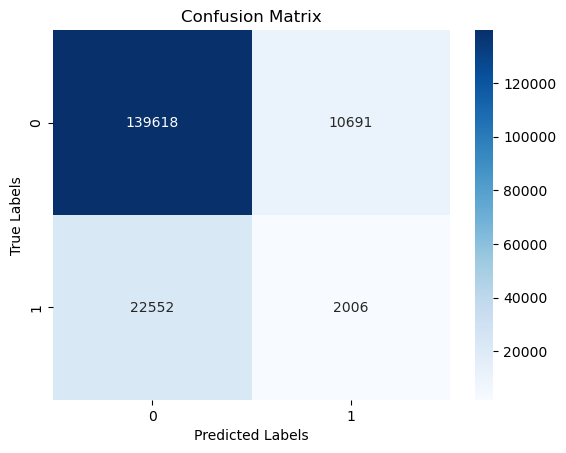

In [14]:
# Test set을 사용해 결과 확인
# 예상 이익금이 0원 이상이면 모두에게 대출해 줌

# Test set을 모델에 적용
y_pred1 = linear_model.predict(X_test)
y_pred_test = (y_pred1 < 0).astype(int)

# Test set을 모델에 적용시킨 결과 Confusion Matrix 그리기
cm = confusion_matrix(y_test_1['loan_not_access'], y_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [15]:
# 모델의 평가 지표 확인

tn = cm[0][0]
fp = cm[0][1]
fn = cm[1][0]
tp = cm[1][1]

# accuracy, sensitivity, specificity, f1_score
accuracy = (tn + tp)/(tn + fn + fp + tp)
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
precision = tp / (tp+fp)
recall = specificity
f1_score = 2*precision*recall / (precision + recall)

print('accuracy     : ', accuracy)
print('sensitivity  : ', sensitivity)
print('specificity  : ', specificity)
print('f1_score     : ', f1_score)

accuracy     :  0.8098955205956527
sensitivity  :  0.08168417623584982
specificity  :  0.9288731878995935
f1_score     :  0.27004822177620275


## 주어진 data (lendingclub_train.dta) 이익금 확인

In [16]:
# 이익금을 확인하기 위해 사후 변수들이 필요해 원래 데이터 파일 불러오기
file_name2 = '/Users/limdonggeon/Desktop/SNU_FINTECH/Statics_DataScience_Statics/team_project/lendingclub_train.dta'
df_all = pd.read_stata(file_name2)


In [17]:
# 전체 데이터셋에서
# 수익률, 총 받은 금액, 총 투자한 금액, 총 순이익
print(sum(df_all['total_pymnt'])/sum(df_all['funded_amnt']))
print(sum(df_all['total_pymnt']))
print(sum(df_all['funded_amnt']))
print(sum(df_all['total_pymnt']) - sum(df_all['funded_amnt']))


1.0908315080802833
13013512253.598719
11929901325
1083610928.5987186


In [18]:
# 테스트 데이터셋에서
# 수익률, 총 받은 금액, 총 투자한 금액, 총 순이익
df_test = df_all.loc[y_test.index]
print(sum(df_test['total_pymnt'])/sum(df_test['funded_amnt']))
print(sum(df_test['total_pymnt']))
print(sum(df_test['funded_amnt']))
print(sum(df_test['total_pymnt']) - sum(df_test['funded_amnt']))


1.0905922431935813
2596459846.307935
2380779675
215680171.30793524


In [19]:
# 테스트 데이터셋에서 모델링한 결과
# 수익률, 총 받은 금액, 총 투자한 금액, 총 순이익
df_test_loan_access = df_all.loc[y_test[y_pred_test == 0].index]
print(sum(df_test_loan_access['total_pymnt'])/sum(df_test_loan_access['funded_amnt']))
print(sum(df_test_loan_access['total_pymnt']))
print(sum(df_test_loan_access['funded_amnt']))
print(sum(df_test_loan_access['total_pymnt']) - sum(df_test_loan_access['funded_amnt']))


1.091602040488643
2537673298.232614
2324723850
212949448.23261404


## Out of data (lendingclub_test.dta) 적용

In [20]:
# Out of Data 파일 불러오기
file_name_out_of_set = '/Users/limdonggeon/Desktop/SNU_FINTECH/Statics_DataScience_Statics/team_project/lendingclub_test.dta'
df_out_of_set = pd.read_stata(file_name_out_of_set)


In [21]:
df_out_of_set.shape

(218584, 334)

In [22]:
# 돈을 벌어다 주는 금액 remains 설정
df_out_of_set['remains'] = (df_out_of_set['total_pymnt']-df_out_of_set['funded_amnt'])

/var/folders/fs/zfypqyv96hs22x794hfx0ycm0000gn/T/ipykernel_1322/3193545492.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out_of_set['remains'] = (df_out_of_set['total_pymnt']-df_out_of_set['funded_amnt'])


In [23]:
# 돈을 벌어다 주는 loan_not_access 설정
df_out_of_set['loan_not_access'] = np.where(df_out_of_set['funded_amnt'] > df_out_of_set['total_pymnt'], 1, 0)
len(df_out_of_set[df_out_of_set['loan_not_access']==1])

/var/folders/fs/zfypqyv96hs22x794hfx0ycm0000gn/T/ipykernel_1322/2614212035.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out_of_set['loan_not_access'] = np.where(df_out_of_set['funded_amnt'] > df_out_of_set['total_pymnt'], 1, 0)


30300

In [24]:
# 위의 데이터 셋에서 사용한 변수들만 사용
df_out_of_set2 = df_out_of_set[df_data.columns]


In [25]:
# Out of test를 
# X와 y로 데이터 분리
X_out = df_out_of_set2.drop(['loan_not_access','remains'], axis=1)
y_out_test = df_out_of_set2[['loan_not_access','remains']]

# 수치형 변수들만 scaling 필요
numerical_cols = ['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'delinq_2yrs', 'open_acc', 'fico_range_low',
        'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'chargeoff_within_12_mths', 'pub_rec_bankruptcies', 'tax_liens',]

# 수치형 변수들을 위 쪽의 train set과 똑같이 scaling 진행
X_out_numeric = scaler.transform(X_out[numerical_cols])         # train set과 scaling 똑같이 적용

# 더미변수도 추가해 Out of test 데이터 셋 구성 다시하기
X_out_test = np.hstack((X_out_numeric, X_out.drop(numerical_cols, axis = 1)))

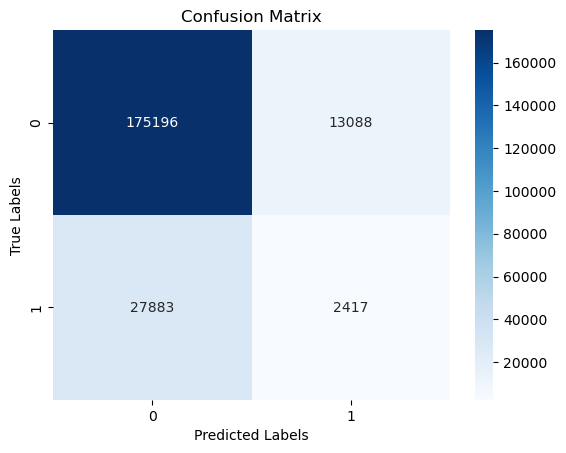

In [26]:
# Out of Test set을 모델에 적용
y_pred_out = linear_model.predict(X_out_test).reshape(-1)
y_pred_out_test = (y_pred_out < 0).astype(int)

# Out of Test set을 모델에 적용시킨 결과 Confusion Matrix 그리기
cm_out = confusion_matrix(y_out_test['loan_not_access'], y_pred_out_test)
sns.heatmap(cm_out, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [27]:
# 모델의 평가 지표 확인

tn = cm_out[0][0]
fp = cm_out[0][1]
fn = cm_out[1][0]
tp = cm_out[1][1]

# accuracy, sensitivity, specificity, f1_score
accuracy = (tn + tp)/(tn + fn + fp + tp)
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
precision = tp / (tp+fp)
recall = specificity
f1_score = 2*precision*recall / (precision + recall)

print('accuracy     : ', accuracy)
print('sensitivity  : ', sensitivity)
print('specificity  : ', specificity)
print('f1_score     : ', f1_score)

accuracy     :  0.8125617611536069
sensitivity  :  0.07976897689768978
specificity  :  0.9304879862335621
f1_score     :  0.26703402906707624


In [28]:
# Out of data set에서
# 수익률, 총 받은 금액, 총 투자한 금액, 총 순이익

df_out_test = df_out_of_set.loc[y_out_test.index]
print(sum(df_out_test['total_pymnt'])/sum(df_out_test['funded_amnt']))
print(sum(df_out_test['total_pymnt']))
print(sum(df_out_test['funded_amnt']))
print(sum(df_out_test['total_pymnt']) - sum(df_out_test['funded_amnt']))

1.0914570361300966
3257320557.5768466
2984378175
272942382.5768466


In [29]:
# Out of data set에서 모델링한 결과
# 수익률, 총 받은 금액, 총 투자한 금액, 총 순이익

df_out_test_loan_access = df_out_of_set.loc[y_out_test[y_pred_out_test == 0].index]
print(sum(df_out_test_loan_access['total_pymnt'])/sum(df_out_test_loan_access['funded_amnt']))
print(sum(df_out_test_loan_access['total_pymnt']))
print(sum(df_out_test_loan_access['funded_amnt']))
print(sum(df_out_test_loan_access['total_pymnt']) - sum(df_out_test_loan_access['funded_amnt']))

1.0923534938023525
3185339327.1520276
2916033450
269305877.1520276
